# Lab Four: Multi-Layer Perceptron
## Caleb Moore, Blake Gebhardt, Christian Gould
dataset: https://www.kaggle.com/datasets/muonneutrino/us-census-demographic-data

The classification task you will be performing is to predict, for each county, what the child poverty rate will be. You will need to convert this from regression to four levels of classification by quantizing the variable of interest. 

In [609]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import datasets
from numpy.linalg import pinv
import time
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [610]:
# Notebook setup
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

# Load, Split, and Balance (1.5 points total)
[.5 points] (1) Load the data into memory and save it to a pandas data frame. Do not normalize or one-hot encode any of the features until asked to do so later in the rubric. (2) Remove any observations that having missing data. (3) Encode any string data as integers for now. (4) You have the option of keeping the "county" variable or removing it. Be sure to discuss why you decided to keep/remove this variable.

In [611]:
# part one
df = pd.read_csv('./data/acs2015_county_data.csv')
df.head()

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [612]:
# part two 
print(df.shape)
df.dropna(inplace=True)
df.shape
# nice, not many missing values

(3220, 37)


(3218, 37)

In [613]:
# part three 
df.dtypes
# lets take a better look at those state values

CensusId             int64
State               object
County              object
TotalPop             int64
Men                  int64
Women                int64
Hispanic           float64
White              float64
Black              float64
Native             float64
Asian              float64
Pacific            float64
Citizen              int64
Income             float64
IncomeErr          float64
IncomePerCap         int64
IncomePerCapErr      int64
Poverty            float64
ChildPoverty       float64
Professional       float64
Service            float64
Office             float64
Construction       float64
Production         float64
Drive              float64
Carpool            float64
Transit            float64
Walk               float64
OtherTransp        float64
WorkAtHome         float64
MeanCommute        float64
Employed             int64
PrivateWork        float64
PublicWork         float64
SelfEmployed       float64
FamilyWork         float64
Unemployment       float64
d

In [614]:
print('number of states', len(df.State.unique()))
df.State.unique()
# States are redundant, since we have the county name, we can drop state
df.drop('State', axis=1, inplace=True)

number of states 52


In [615]:
# double checking the dtypes
df.dtypes

CensusId             int64
County              object
TotalPop             int64
Men                  int64
Women                int64
Hispanic           float64
White              float64
Black              float64
Native             float64
Asian              float64
Pacific            float64
Citizen              int64
Income             float64
IncomeErr          float64
IncomePerCap         int64
IncomePerCapErr      int64
Poverty            float64
ChildPoverty       float64
Professional       float64
Service            float64
Office             float64
Construction       float64
Production         float64
Drive              float64
Carpool            float64
Transit            float64
Walk               float64
OtherTransp        float64
WorkAtHome         float64
MeanCommute        float64
Employed             int64
PrivateWork        float64
PublicWork         float64
SelfEmployed       float64
FamilyWork         float64
Unemployment       float64
dtype: object

In [616]:
# part four
print('number of counties', len(df.County.unique()))
df.County.unique()

number of counties 1926


array(['Autauga', 'Baldwin', 'Barbour', ..., 'Villalba', 'Yabucoa',
       'Yauco'], dtype=object)

In [617]:
# Encode the counties

# lets encode them
initial_list = df.County.unique()
codes = {initial_list[i]: i for i in range(len(initial_list))}

df = df.replace(codes)

[.5 points] Balance the dataset so that about the same number of instances are within each class. Choose a method for balancing the dataset and explain your reasoning for selecting this method. One option is to choose quantization thresholds for the "ChildPoverty" variable that equally divide the data into four classes. Should balancing of the dataset be done for both the training and testing set? Explain.

In [618]:
print('there are',len(df["ChildPoverty"].unique()), 'different ChildPoverty values')
# lets try and simplify those into four classes
print('we will want',int(len(df)/4), 'ish instances in each class to create somewhat equal quartiles')

def categorise(row):  
    if row['ChildPoverty'] > 0 and row['ChildPoverty'] <= 16:
        return 'fourth_quartile'
    elif row['ChildPoverty'] > 16 and row['ChildPoverty'] <= 23:
        return 'third_quartile'
    elif row['ChildPoverty'] > 23  and row['ChildPoverty'] <= 30:
        return 'second_quartile'
    return 'first_quartile'

df['poverty_quartile'] = df.apply(lambda row: categorise(row), axis=1)

print(df['poverty_quartile'].value_counts())
# yes, we will want to balance on the set as a whole to ensure we do not skew our model compared to what it is going to attempt to predict

there are 544 different ChildPoverty values
we will want 804 ish instances in each class to create somewhat equal quartiles
third_quartile     871
first_quartile     807
fourth_quartile    778
second_quartile    762
Name: poverty_quartile, dtype: int64


[.5 points] Assume you are equally interested in the classification performance for each class in the dataset. Split the dataset into 80% for training and 20% for testing. There is NO NEED to split the data multiple times for this lab.

Note: You will need to one hot encode the target, but do not one hot encode the categorical data until instructed to do so in the lab. 

In [619]:
y = df['poverty_quartile']
#one hot encode the poverty quartile
y = pd.get_dummies(y)

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['poverty_quartile', 'ChildPoverty']), y, test_size=0.20, random_state=1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2574, 35)
(2574, 4)
(644, 35)
(644, 4)


# Pre-processing and Initial Modeling (2.5 points total)
You will be using a two layer perceptron from class for the next few parts of the rubric. There are several versions of the two layer perceptron covered in class, with example code. When selecting an example two layer network from class be sure that you use: (1) vectorized gradient computation, (2) mini-batching, (3) cross entropy loss, and (4) proper Glorot initialization, at a minimum. There is no need to use momentum or learning rate reduction (assuming you choose a sufficiently small learning rate). It is recommended to use sigmoids throughout the network, but not required.

[.5 points] Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Do not normalize or one-hot encode the data (not yet). Be sure that training converges by graphing the loss function versus the number of epochs. 

The following code is take from Dr. Larsen's Notebook 7.


In [620]:
import numpy as np
from scipy.special import expit
import sys
import pandas as pd

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
# Start with the following functions:
#    init
#    encode_labels
#    initialize weights
#    sigmoid
#    add bias (vector of ones)
#    objective function (cost and regularizer)
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term

# now let's add in the following functions:
#    feedforward
#    fit and predict
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2)
            
            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)

            self.W1 -= self.eta * grad1
            self.W2 -= self.eta * grad2
            
        return self

class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    # just need a different gradient calculation
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2

In [621]:
# Function to convert data into format to test accuracy with
def convert_data(y_pred):
  returnMe = pd.DataFrame()
  
  returnMe['first_quartile'] = (y_pred == 0)
  returnMe['second_quartile'] = (y_pred == 1)
  returnMe['third_quartile'] = (y_pred == 2)
  returnMe['fourth_quartile'] = (y_pred == 3)

  return returnMe

Epoch: 500/500

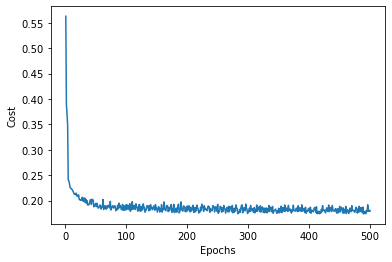

Accuracy: 0.3695652173913043


In [622]:
# train the model
model = TwoLayerPerceptronVectorized(n_hidden=30, C=0.0, epochs=500, eta=0.001, random_state=42)
model.fit(X_train, y_train, print_progress=True)
# plot the loss over time to ensure convergence
plt.plot(range(1, len(model.cost_)+1), model.cost_)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

# evaluate the model on the test set
y_pred = model.predict(X_test)

# convert y_pred into a one-hot encoded dataframe
y_pred = convert_data(y_pred)

# Get accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [623]:
print(y_test)

      first_quartile  fourth_quartile  second_quartile  third_quartile
2191               0                0                1               0
791                0                1                0               0
2385               0                1                0               0
161                0                0                1               0
255                0                0                0               1
...              ...              ...              ...             ...
2689               0                0                0               1
2405               0                0                0               1
1081               0                0                1               0
2370               0                1                0               0
2264               0                1                0               0

[644 rows x 4 columns]


[.5 points] Now (1) normalize the continuous numeric feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.  

Epoch: 500/500

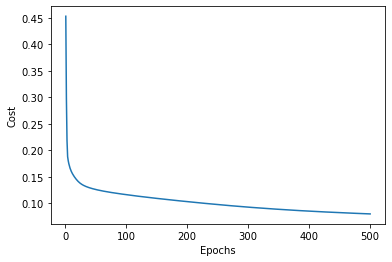

Accuracy: 0.7018633540372671


In [624]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# define the TwoLayerPerceptron and TwoLayerPerceptronBase classes here

class NormalizedTwoLayerPerceptron(TwoLayerPerceptronVectorized):
    def fit(self, X, y, print_progress=False):
        scaler = StandardScaler()
        X_norm = scaler.fit_transform(X)
        super().fit(X_norm, y, print_progress=print_progress)
        self.scaler_ = scaler
        
    def predict(self, X):
        X_norm = self.scaler_.transform(X)
        return super().predict(X_norm)

# train the model
model = NormalizedTwoLayerPerceptron(n_hidden=30, C=0.0, epochs=500, eta=0.001, random_state=42)
model.fit(X_train, y_train, print_progress=True)

# plot the loss over time to ensure convergence
plt.plot(range(1, len(model.cost_)+1), model.cost_)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

# evaluate the model on the test set
y_pred = model.predict(X_test)

# convert y_pred into a one-hot encoded dataframe
y_pred = convert_data(y_pred)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


[.5 points] Now(1) normalize the continuous numeric feature data AND (2) one hot encode the categorical data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.

In [625]:
df.head()

,CensusId,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,...,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,poverty_quartile
0,1001,0,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,...,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6,third_quartile
1,1003,1,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,...,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5,third_quartile
2,1005,2,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,...,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6,first_quartile
3,1007,3,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,...,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3,second_quartile
4,1009,4,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,...,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7,second_quartile


In [626]:
y = df['poverty_quartile']
y = pd.get_dummies(y)

X_categorical = df[['County']]
X = df.drop(['poverty_quartile', 'ChildPoverty', 'County'], axis=1)

# Normalize the numeric feature data
X_norm = StandardScaler().fit_transform(X)

# One-hot encode the categorical features
X_categorical = pd.get_dummies(X_categorical)

# Concatenate the numeric and categorical features
X = np.concatenate((X_norm, X_categorical), axis=1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

Epoch: 500/500

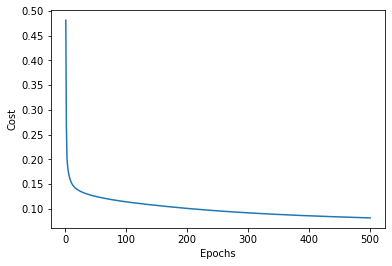

Accuracy: 0.7375776397515528


In [627]:
# train the model
model = NormalizedTwoLayerPerceptron(n_hidden=30, C=0.0, epochs=500, eta=0.001, random_state=42)
model.fit(X_train, y_train, print_progress=True)

# plot the loss over time to ensure convergence
plt.plot(range(1, len(model.cost_)+1), model.cost_)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

# evaluate the model on the test set
y_pred = model.predict(X_test)

# convert y_pred into a one-hot encoded dataframe
y_pred = convert_data(y_pred)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

[1 points] Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances.  

Use one-hot encoding and normalization on the dataset for the remainder of this lab assignment.

# Comparing performance

### First Model
* The first model was able to get a decent score of about 38% accuracy. This is a good start, but we can do better. We were able to successfully beat a random choice, which would get about 25% accuracy, but we want to do better than that. The first model does not have any normalization or one-hot encoding on the input data, so there are some columns that are taking on a much larger weight than others. This is why we see such a large difference in accuracy between the first and second model.

### Second Model
* The second model was able to get a score of about 70% accuracy. This is a huge improvement over the first model. All we did was add a normalization! This is a great example of how important normalization is. The second model is still not as good as the third model, since the second model does not one-hot encode the colunn of county. That is only one column, so the difference in accuracy is not as large as the difference between the first and second model.

### Third Model
* The third model was able to get a score of about 73% accuracy. The slight improvement is because of the one hot encoding of the county column. This is a great example of how important one-hot encoding is. If there were many more columns that were not one-hot encoded, the difference in accuracy would be much larger.

# Modeling (5 points total)
[1 points] Add support for a third layer in the multi-layer perceptron. Add support for saving (and plotting after training is completed) the average magnitude of the gradient for each layer, for each epoch (like we did in the flipped module for back propagation). For magnitude calculation, you are free to use either the average absolute values or the L1/L2 norm.
Quantify the performance of the model and graph the magnitudes for each layer versus the number of epochs.

In [628]:
class ThreeLayerPerceptronBase(TwoLayerPerceptronBase):
    def __init__(self, n_hidden_1=30, n_hidden_2=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        super().__init__(n_hidden=n_hidden_1, C=C, epochs=epochs, eta=eta, random_state=random_state)
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1) * self.n_hidden_1
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden_1, self.n_features_ + 1)  # reshape to be W

        W2_num_elems = (self.n_hidden_1 + 1) * self.n_hidden_2
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden_2, self.n_hidden_1 + 1)

        W3_num_elems = (self.n_hidden_2 + 1) * self.n_output_
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W3.reshape(self.n_output_, self.n_hidden_2 + 1)

        return W1, W2, W3

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2))

    def _cost(self, A4, Y_enc, W1, W2, W3):
        '''Get the objective function value'''
        cost = np.mean((Y_enc - A4) ** 2)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term


In [629]:
class ThreeLayerPerceptron(ThreeLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, W3):
        """Compute feedforward step"""
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._sigmoid(Z3)
        return A1, Z1, A2, Z2, A3, Z3, A4

    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        """ Compute gradient step using backpropagation. """
        V3 = -2 * (Y_enc - A4) * A4 * (1 - A4)
        V2 = A3 * (1 - A3) * (W3.T @ V3)
        V1 = A2 * (1 - A2) * (W2.T @ V2[1:, :])

        grad3 = V3 @ A3.T
        grad2 = V2[1:, :] @ A2.T
        grad1 = V1[1:, :] @ A1.T

        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C

        return grad1, grad2, grad3

    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, A4 = self._feedforward(X, self.W1, self.W2, self.W3)
        y_pred = np.argmax(A4, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3 = self._initialize_weights()

        self.cost_ = []
        self.grad_mag_ = {'W1': [], 'W2': [], 'W3': []}  # Added line to store gradient magnitudes
        for i in range(self.epochs):

            if print_progress > 0 and (i + 1) % print_progress == 0:
                sys.stderr.write('\rEpoch: %d/%d' % (i + 1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3, Z3, A4 = self._feedforward(X_data, self.W1, self.W2, self.W3)

            cost = self._cost(A4, Y_enc, self.W1, self.W2, self.W3)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad1, grad2, grad3 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, Z1=Z1, Z2=Z2, Z3=Z3, Y_enc=Y_enc,
                                                     W1=self.W1, W2=self.W2, W3=self.W3)

            # Save average gradient magnitudes
            self.grad_mag_['W1'].append(np.mean(np.abs(grad1)))
            self.grad_mag_['W2'].append(np.mean(np.abs(grad2)))
            self.grad_mag_['W3'].append(np.mean(np.abs(grad3)))

            self.W1 -= self.eta * grad1
            self.W2 -= self.eta * grad2
            self.W3 -= self.eta * grad3

        return self

    def plot_gradient_magnitudes(self):
        """Plot the average gradient magnitudes for each layer."""
        plt.plot(self.grad_mag_['W1'], label='W1', linestyle='-', marker='o')
        plt.plot(self.grad_mag_['W2'], label='W2', linestyle='-', marker='s')
        plt.plot(self.grad_mag_['W3'], label='W3', linestyle='-', marker='d')
        
        plt.ylabel('Average Gradient Magnitude')
        plt.xlabel('Epochs')
        plt.legend(loc='upper right')
        plt.grid()
        plt.show()

### Test the three-layer model

Epoch: 1000/1000

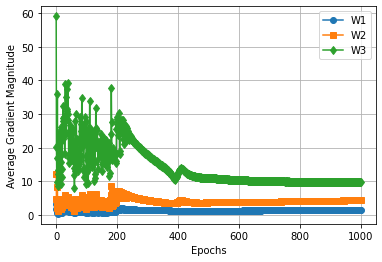

Accuracy: 75.31%


In [630]:
# run the three layer model
nn = ThreeLayerPerceptron(n_hidden_1=50, n_hidden_2=50, C=0.0, epochs=1000, eta=0.001, random_state=1)
nn.fit(X_train, y_train, print_progress=100)

nn.plot_gradient_magnitudes()

# Check the accuracy
y_pred = nn.predict(X_test)
y_pred = convert_data(y_pred)
print('Accuracy: %.2f%%' % (100 * accuracy_score(y_test, y_pred)))

[1 points] Repeat the previous step, adding support for a fourth layer.

In [631]:
class FourLayerPerceptron(ThreeLayerPerceptron):
    def __init__(self, n_hidden1=30, n_hidden2=30, n_hidden3=30, epochs=500, eta=0.001, random_state=None, l2_C=0.0):
        np.random.seed(random_state)
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.n_hidden3 = n_hidden3
        self.l2_C = l2_C
        self.epochs = epochs
        self.eta = eta
        self.random_state = random_state

    def _feedforward(self, X, W1, W2, W3, W4):
        """Compute feedforward step"""
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._sigmoid(Z3)
        A4 = self._add_bias_unit(A4, how='row')
        Z4 = W4 @ A4
        A5 = self._sigmoid(Z4)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5

    def _get_gradient(self, A1, A2, A3, A4, A5, Z1, Z2, Z3, Z4, Y_enc, W1, W2, W3, W4):
        """ Compute gradient step using backpropagation. """
        V4 = -2 * (Y_enc - A5) * A5 * (1 - A5)
        V3 = A4 * (1 - A4) * (W4.T @ V4)
        V2 = A3 * (1 - A3) * (W3.T @ V3[1:, :])
        V1 = A2 * (1 - A2) * (W2.T @ V2[1:, :])

        grad4 = V4 @ A4.T
        grad3 = V3[1:, :] @ A3.T
        grad2 = V2[1:, :] @ A2.T
        grad1 = V1[1:, :] @ A1.T

        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C
        grad4[:, 1:] += W4[:, 1:] * self.l2_C

        return grad1, grad2, grad3, grad4

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_hidden1 * (self.n_features_ + 1))
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden1, self.n_features_ + 1)  # reshape to be W

        W2_num_elems = (self.n_hidden2 * (self.n_hidden1 + 1))
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_hidden2, self.n_hidden1 + 1)

        W3_num_elems = (self.n_hidden3 * (self.n_hidden2 + 1))
        W3 = np.random.uniform(-1.0, 1.0, size=W3_num_elems)
        W3 = W3.reshape(self.n_hidden3, self.n_hidden2 + 1)

        W4_num_elems = (self.n_output_ * (self.n_hidden3 + 1))
        W4 = np.random.uniform(-1.0, 1.0, size=W4_num_elems)
        W4 = W4.reshape(self.n_output_, self.n_hidden3 + 1)

        return W1, W2, W3, W4

    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, A5 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4)
        y_pred = np.argmax(A5, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4 = self._initialize_weights()

        self.cost_ = []
        self.grad_mag_ = {'W1': [], 'W2': [], 'W3': [], 'W4': []}  # Added line to store gradient magnitudes
        for i in range(self.epochs):

            if print_progress > 0 and (i + 1) % print_progress == 0:
                sys.stderr.write('\rEpoch: %d/%d' % (i + 1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5 = self._feedforward(X_data, self.W1, self.W2, self.W3, self.W4)

            cost = self._cost(A5, Y_enc, self.W1, self.W2, self.W3, self.W4)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad1, grad2, grad3, grad4 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Y_enc=Y_enc,
                                                            W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4)

            # Save average gradient magnitudes
            self.grad_mag_['W1'].append(np.mean(np.abs(grad1)))
            self.grad_mag_['W2'].append(np.mean(np.abs(grad2)))
            self.grad_mag_['W3'].append(np.mean(np.abs(grad3)))
            self.grad_mag_['W4'].append(np.mean(np.abs(grad4)))

            self.W1 -= self.eta * grad1
            self.W2 -= self.eta * grad2
            self.W3 -= self.eta * grad3
            self.W4 -= self.eta * grad4

        return self

    def _cost(self, A5, Y_enc, W1, W2, W3, W4):
        """Compute the cost function."""
        cost = np.mean((Y_enc - A5)**2)
        L2_term = (self.l2_C * (np.sum(W1[:, 1:] ** 2) +
                                np.sum(W2[:, 1:] ** 2) +
                                np.sum(W3[:, 1:] ** 2) +
                                np.sum(W4[:, 1:] ** 2)))
        return cost + L2_term

    def plot_gradient_magnitudes(self):
        """Plot the average gradient magnitudes for each layer."""
        plt.plot(self.grad_mag_['W1'], label='W1', linestyle='-', marker='o')
        plt.plot(self.grad_mag_['W2'], label='W2', linestyle='-', marker='s')
        plt.plot(self.grad_mag_['W3'], label='W3', linestyle='-', marker='d')
        plt.plot(self.grad_mag_['W4'], label='W4', linestyle='-', marker='x')

        plt.ylabel('Average Gradient Magnitude')
        plt.xlabel('Epochs')
        plt.legend(loc='upper right')
        plt.grid()
        plt.show()


Epoch: 500/500

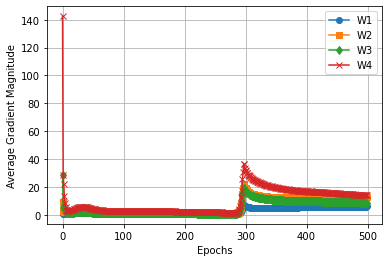

Accuracy: 75.93%


In [657]:
# run the four layer model
nn = FourLayerPerceptron(n_hidden1=15, n_hidden2=15, n_hidden3=15, l2_C=0.0, epochs=500, eta=0.001, random_state=1)
nn.fit(X_train, y_train, print_progress=1)

nn.plot_gradient_magnitudes()

# Check the accuracy
y_pred = nn.predict(X_test)
y_pred = convert_data(y_pred)
print('Accuracy: %.2f%%' % (100 * accuracy_score(y_test, y_pred)))


[1 points] Repeat the previous step, adding support for a fifth layer.

In [649]:
class FiveLayerPerceptron(FourLayerPerceptron):
    def __init__(self, n_hidden1=30, n_hidden2=30, n_hidden3=30, n_hidden4=30, epochs=500, eta=0.001, random_state=None, l2_C=0.0):
        super().__init__(n_hidden1, n_hidden2, n_hidden3, epochs, eta, random_state, l2_C)
        self.n_hidden4 = n_hidden4

    # update feedforward method to include 5 layers
    def _feedforward(self, X, W1, W2, W3, W4, W5):
        """Compute feedforward step for a five-layer perceptron."""
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        
        Z3 = W3 @ A3
        A4 = self._sigmoid(Z3)
        A4 = self._add_bias_unit(A4, how='row')
        
        Z4 = W4 @ A4
        A5 = self._sigmoid(Z4)
        A5 = self._add_bias_unit(A5, how='row')
        
        Z5 = W5 @ A5
        A6 = self._sigmoid(Z5)

        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6


    # Add gradient calculation for the fifth layer
    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        """ Compute gradient step using backpropagation. """
        V5 = -2 * (Y_enc - A6) * A6 * (1 - A6)
        V4 = A5 * (1 - A5) * (W5.T @ V5)
        V3 = A4 * (1 - A4) * (W4.T @ V4[1:, :])
        V2 = A3 * (1 - A3) * (W3.T @ V3[1:, :])
        V1 = A2 * (1 - A2) * (W2.T @ V2[1:, :])

        grad5 = V5 @ A5.T
        grad4 = V4[1:, :] @ A4.T
        grad3 = V3[1:, :] @ A3.T
        grad2 = V2[1:, :] @ A2.T
        grad1 = V1[1:, :] @ A1.T

        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C
        grad4[:, 1:] += W4[:, 1:] * self.l2_C
        grad5[:, 1:] += W5[:, 1:] * self.l2_C

        return grad1, grad2, grad3, grad4, grad5

    # Add the fifth layer to the weight initialization
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1, W2, W3, _ = super()._initialize_weights()

        W4_num_elems = (self.n_hidden4 * (self.n_hidden3 + 1))
        W4 = np.random.uniform(-1.0, 1.0, size=W4_num_elems)
        W4 = W4.reshape(self.n_hidden4, self.n_hidden3 + 1)

        W5_num_elems = (self.n_output_ * (self.n_hidden4 + 1))
        W5 = np.random.uniform(-1.0, 1.0, size=W5_num_elems)
        W5 = W5.reshape(self.n_output_, self.n_hidden4 + 1)

        return W1, W2, W3, W4, W5

    # Add the fifth layer to the prediction function
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, _, _, _, _, A6 = self._feedforward(X, self.W1, self.W2, self.W3, self.W4, self.W5)
        y_pred = np.argmax(A6, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5 = self._initialize_weights()

        self.cost_ = []
        self.grad_mag_ = {'W1': [], 'W2': [], 'W3': [], 'W4': [], 'W5': []}  # Added line to store gradient magnitudes
        for i in range(self.epochs):

            if print_progress > 0 and (i + 1) % print_progress == 0:
                sys.stderr.write('\rEpoch: %d/%d' % (i + 1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data, self.W1, self.W2, self.W3, self.W4, self.W5)

            cost = self._cost(A6, Y_enc, self.W1, self.W2, self.W3, self.W4, self.W5)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad1, grad2, grad3, grad4, grad5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, A5=A5, A6=A6, Z1=Z1, Z2=Z2, Z3=Z3, Z4=Z4, Z5=Z5, Y_enc=Y_enc,
                                                            W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4, W5=self.W5)

            # Save average gradient magnitudes
            self.grad_mag_['W1'].append(np.mean(np.abs(grad1)))
            self.grad_mag_['W2'].append(np.mean(np.abs(grad2)))
            self.grad_mag_['W3'].append(np.mean(np.abs(grad3)))
            self.grad_mag_['W4'].append(np.mean(np.abs(grad4)))
            self.grad_mag_['W5'].append(np.mean(np.abs(grad5)))

            self.W1 -= self.eta * grad1
            self.W2 -= self.eta * grad2
            self.W3 -= self.eta * grad3
            self.W4 -= self.eta * grad4
            self.W5 -= self.eta * grad5

        return self

    def _cost(self, A6, Y_enc, W1, W2, W3, W4, W5):
        """Compute the cost function."""
        cost = np.mean((Y_enc - A6)**2)
        L2_term = (self.l2_C * (np.sum(W1[:, 1:] ** 2) +
                                np.sum(W2[:, 1:] ** 2) +
                                np.sum(W3[:, 1:] ** 2) +
                                np.sum(W4[:, 1:] ** 2) +
                                np.sum(W5[:, 1:] ** 2)
                                ))
        return cost + L2_term

    def plot_gradient_magnitudes(self):
        """Plot the average gradient magnitudes for each layer."""
        plt.plot(self.grad_mag_['W1'], label='W1', linestyle='-', marker='o')
        plt.plot(self.grad_mag_['W2'], label='W2', linestyle='-', marker='s')
        plt.plot(self.grad_mag_['W3'], label='W3', linestyle='-', marker='d')
        plt.plot(self.grad_mag_['W4'], label='W4', linestyle='-', marker='x')
        plt.plot(self.grad_mag_['W5'], label='W5', linestyle='-', marker='v')

        plt.ylabel('Average Gradient Magnitude')
        plt.xlabel('Epochs')
        plt.legend(loc='upper right')
        plt.grid()
        plt.show()

Epoch: 500/500

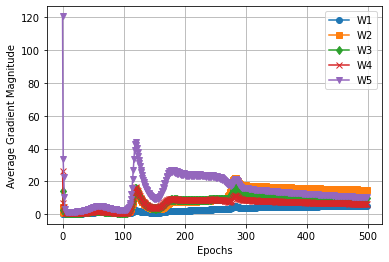

Accuracy: 75.93%


In [664]:
# run the five layer model
num = 16
nn = FiveLayerPerceptron(n_hidden1=num, n_hidden2=num, n_hidden3=num, n_hidden4=num, l2_C=0.0, epochs=500, eta=0.001, random_state=1)
nn.fit(X_train, y_train, print_progress=1)

nn.plot_gradient_magnitudes()

# Check the accuracy
y_pred = nn.predict(X_test)
y_pred = convert_data(y_pred)
print('Accuracy: %.2f%%' % (100 * accuracy_score(y_test, y_pred)))

[2 points] Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network (such as AdaGrad, RMSProps, or AdaDelta). Discuss which adaptive method you chose. Compare the performance of your five layer model with and without the adaptive learning strategy. Do not use AdaM for the adaptive learning technique as it is part of the exceptional work.

# Exceptional Work (1 points total)
5000 level student: You have free reign to provide additional analyses.
One idea (required for 7000 level students):  Implement adaptive momentum (AdaM) in the five layer neural network and quantify the performance. 